In [1]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [2]:
import numpy as np
import pandas as pd
import scanpy as sc

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.21.5 scipy==1.7.3 pandas==1.3.5 scikit-learn==1.0.2 statsmodels==0.13.5 python-igraph==0.10.2 louvain==0.8.0 pynndescent==0.5.8


In [4]:
!mkdir write

In [5]:
results_file = 'write/result.h5ad' 

In [6]:
adata = sc.read_10x_mtx(
    'data/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)    

... writing an h5ad cache file to speedup reading next time


In [7]:
adata

AnnData object with n_obs × n_vars = 13538 × 32738
    var: 'gene_ids'

In [8]:
adata.var_names_make_unique() 

normalizing counts per cell
    finished (0:00:00)


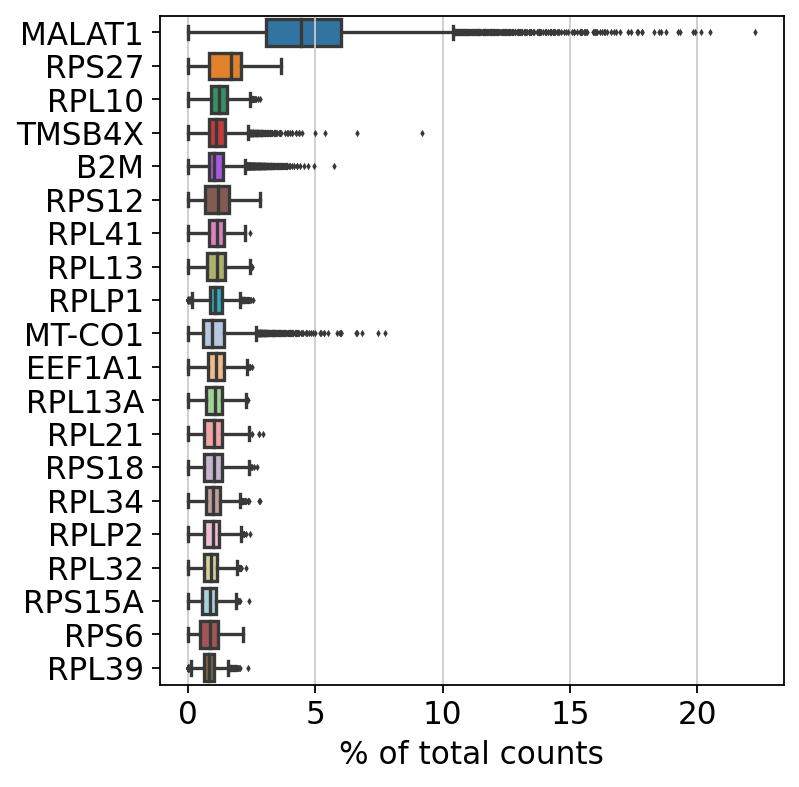

In [9]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [10]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 73 cells that have less than 200 genes expressed
filtered out 15454 genes that are detected in less than 3 cells


In [11]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

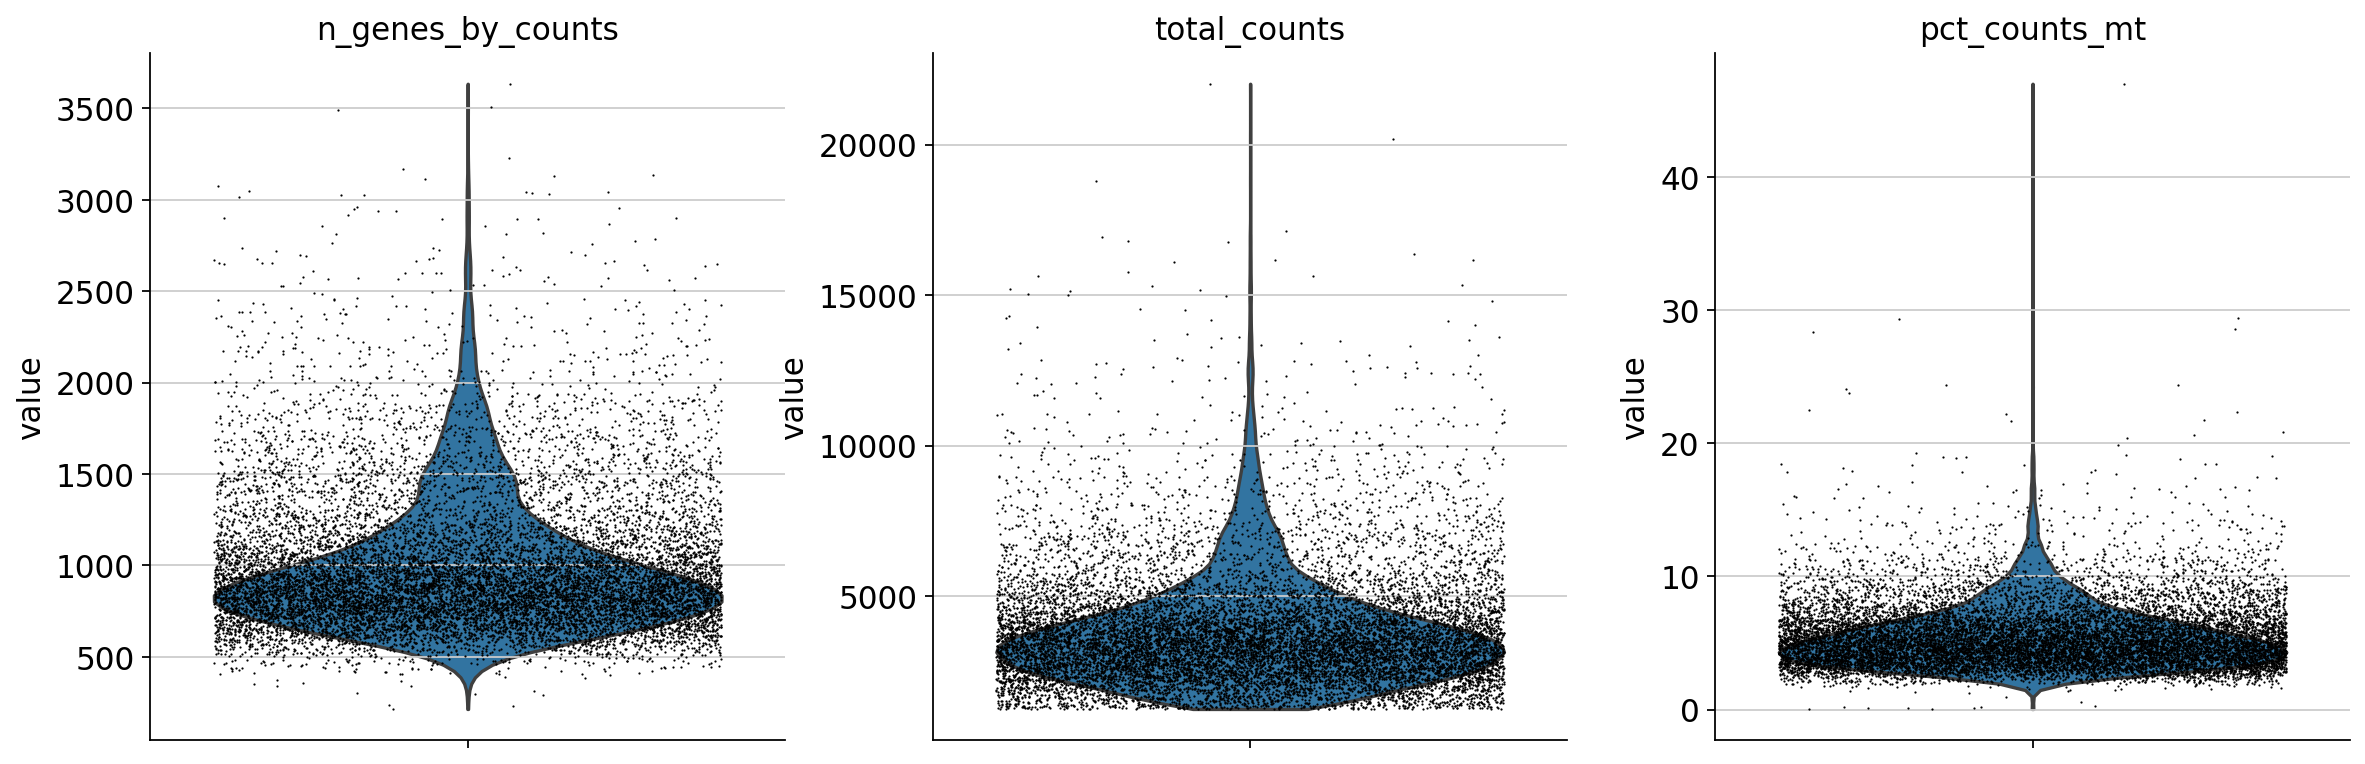

In [12]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

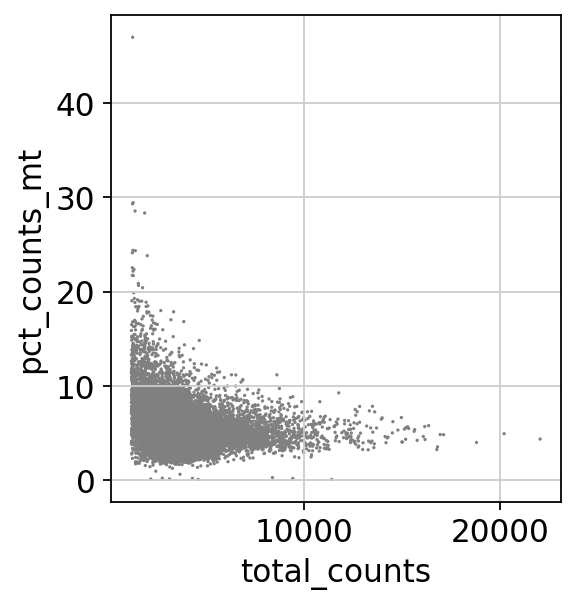

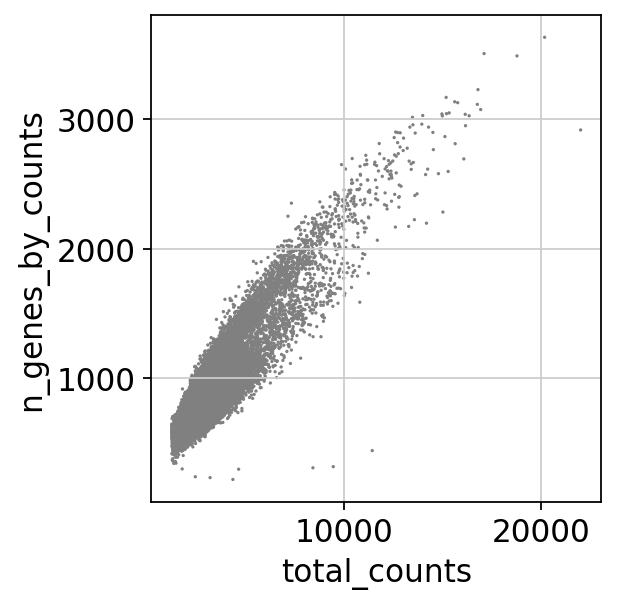

In [13]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [14]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [15]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


/home/aaron/anaconda3/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [16]:
sc.pp.log1p(adata)

In [17]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


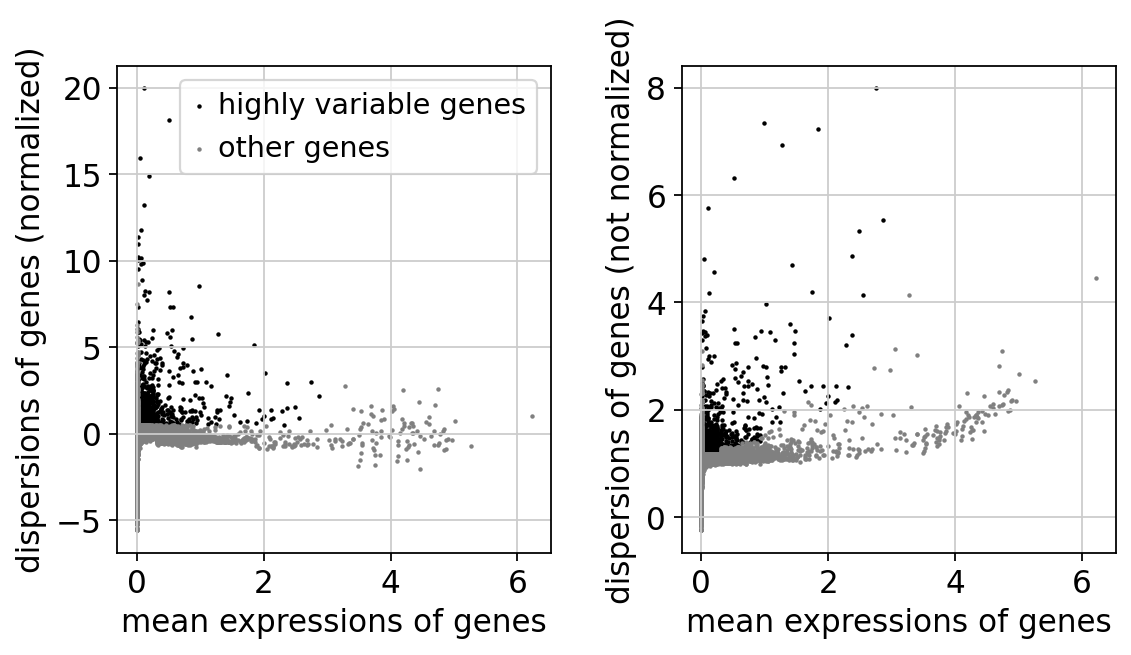

In [18]:
sc.pl.highly_variable_genes(adata)

In [19]:
adata.raw = adata

In [20]:
adata = adata[:, adata.var.highly_variable]

In [21]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:13)


In [22]:
sc.pp.scale(adata, max_value=10)

In [23]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:03)


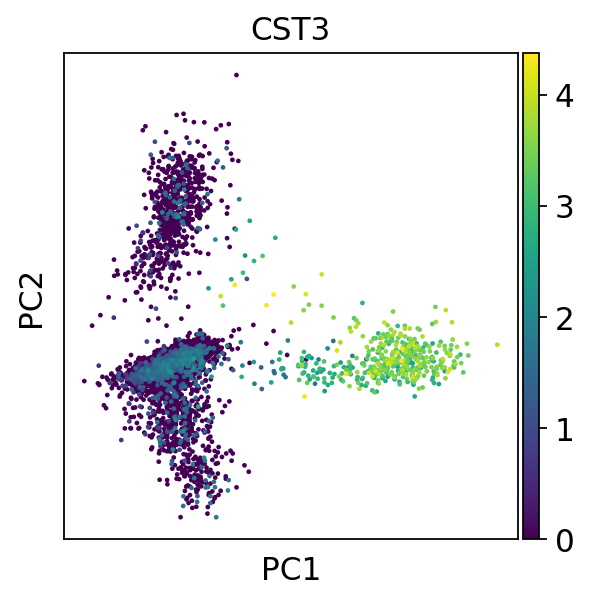

In [24]:
sc.pl.pca(adata, color='CST3')

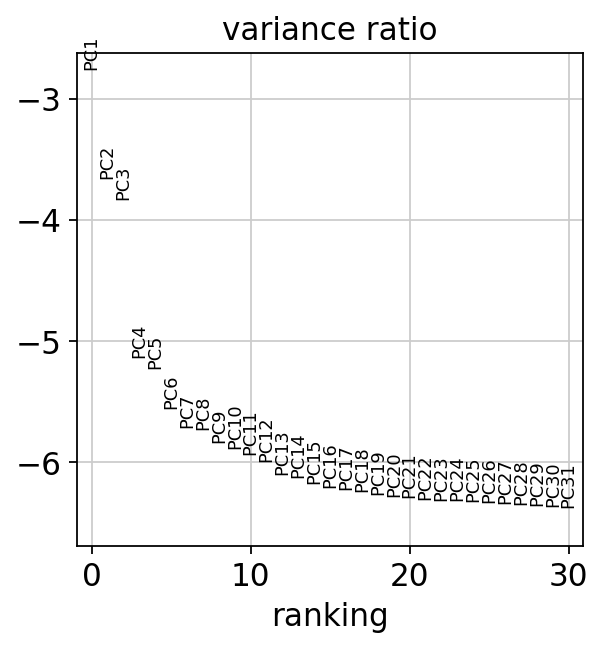

In [25]:
sc.pl.pca_variance_ratio(adata, log=True)

In [26]:
adata.write(results_file)

In [27]:
adata

AnnData object with n_obs × n_vars = 6624 × 1225
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [28]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:08)


In [29]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:15)


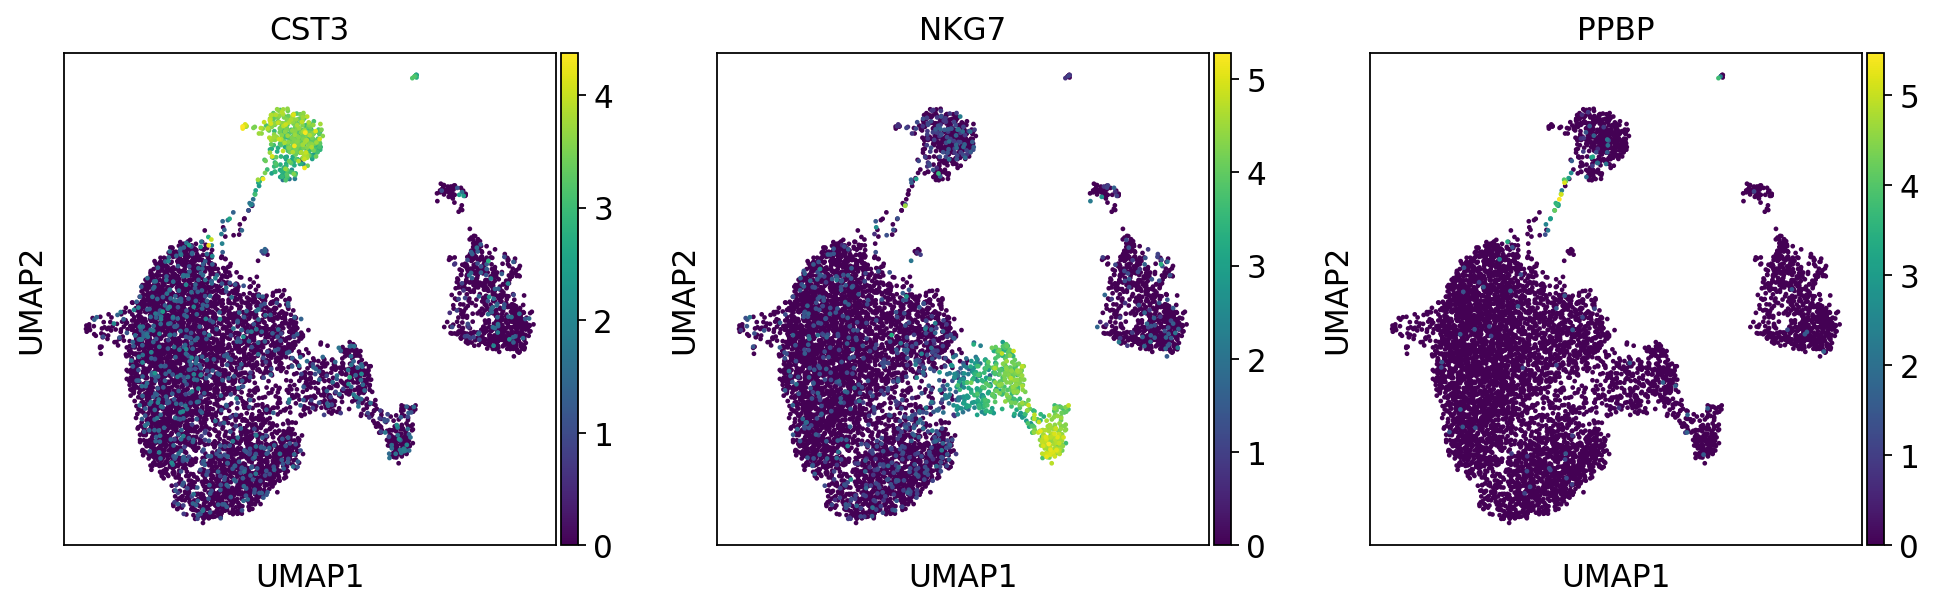

In [30]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])

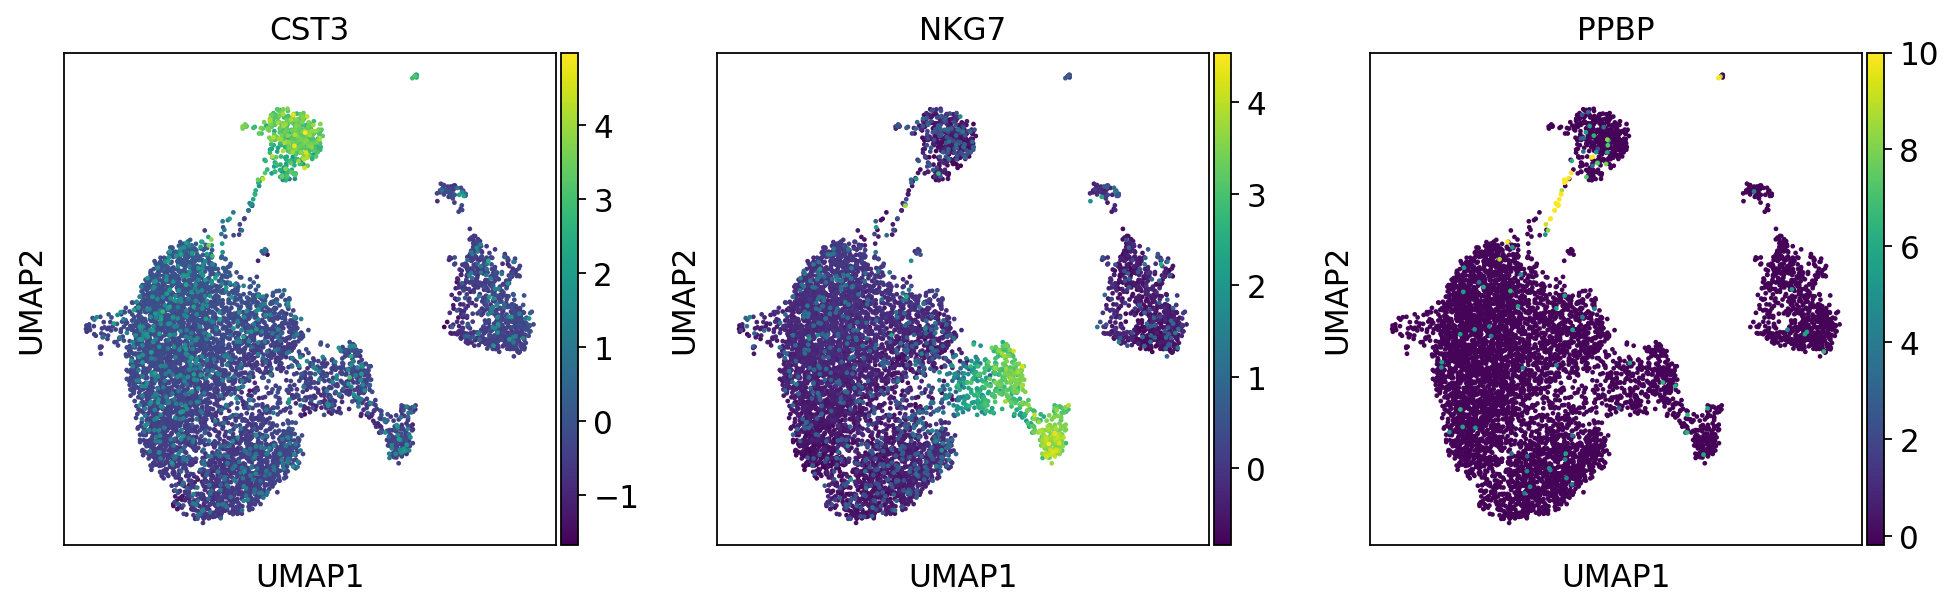

In [31]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)

In [32]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 14 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


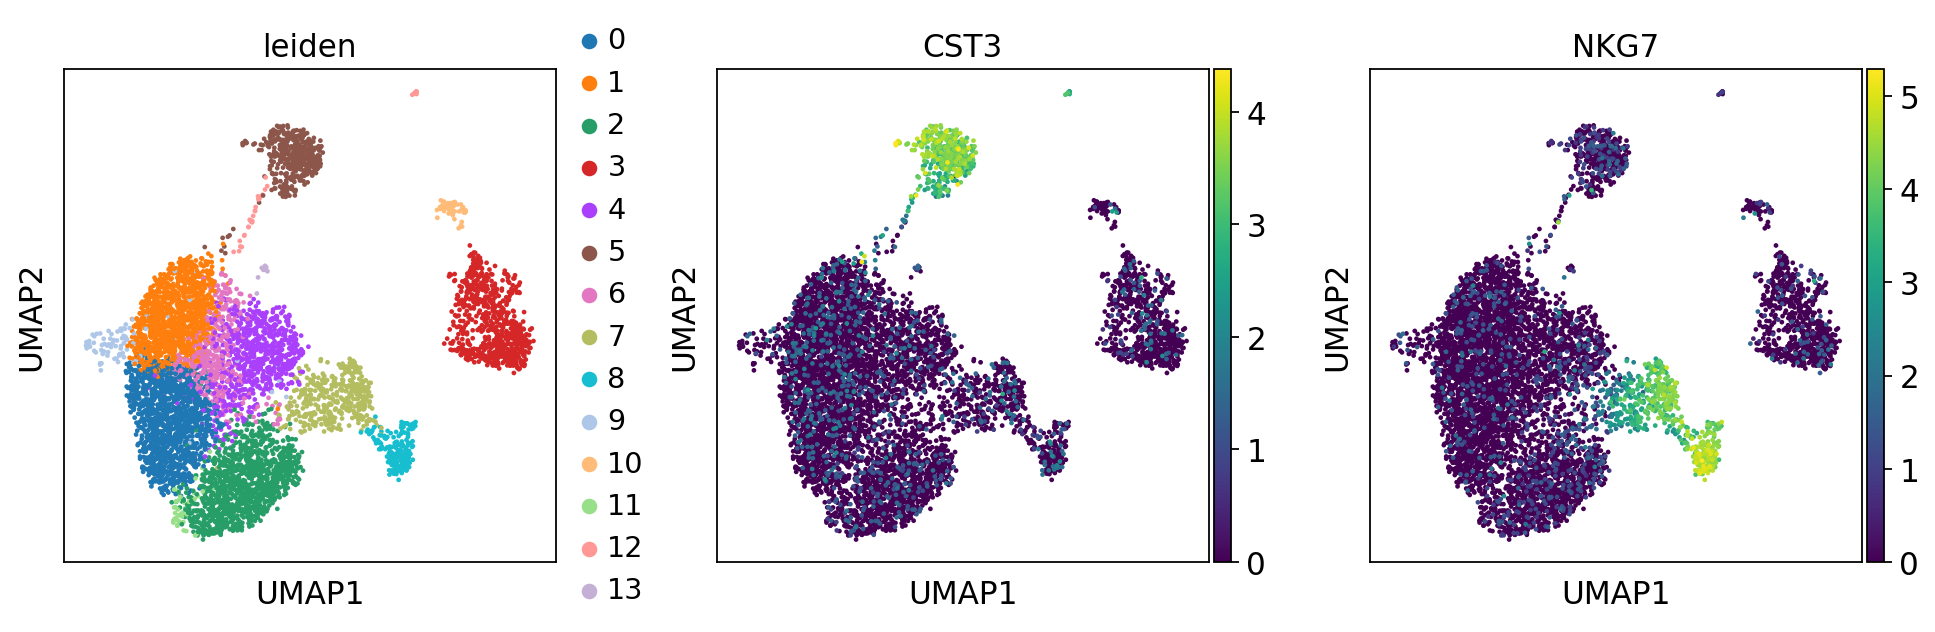

In [33]:
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])

In [34]:
adata.write(results_file)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


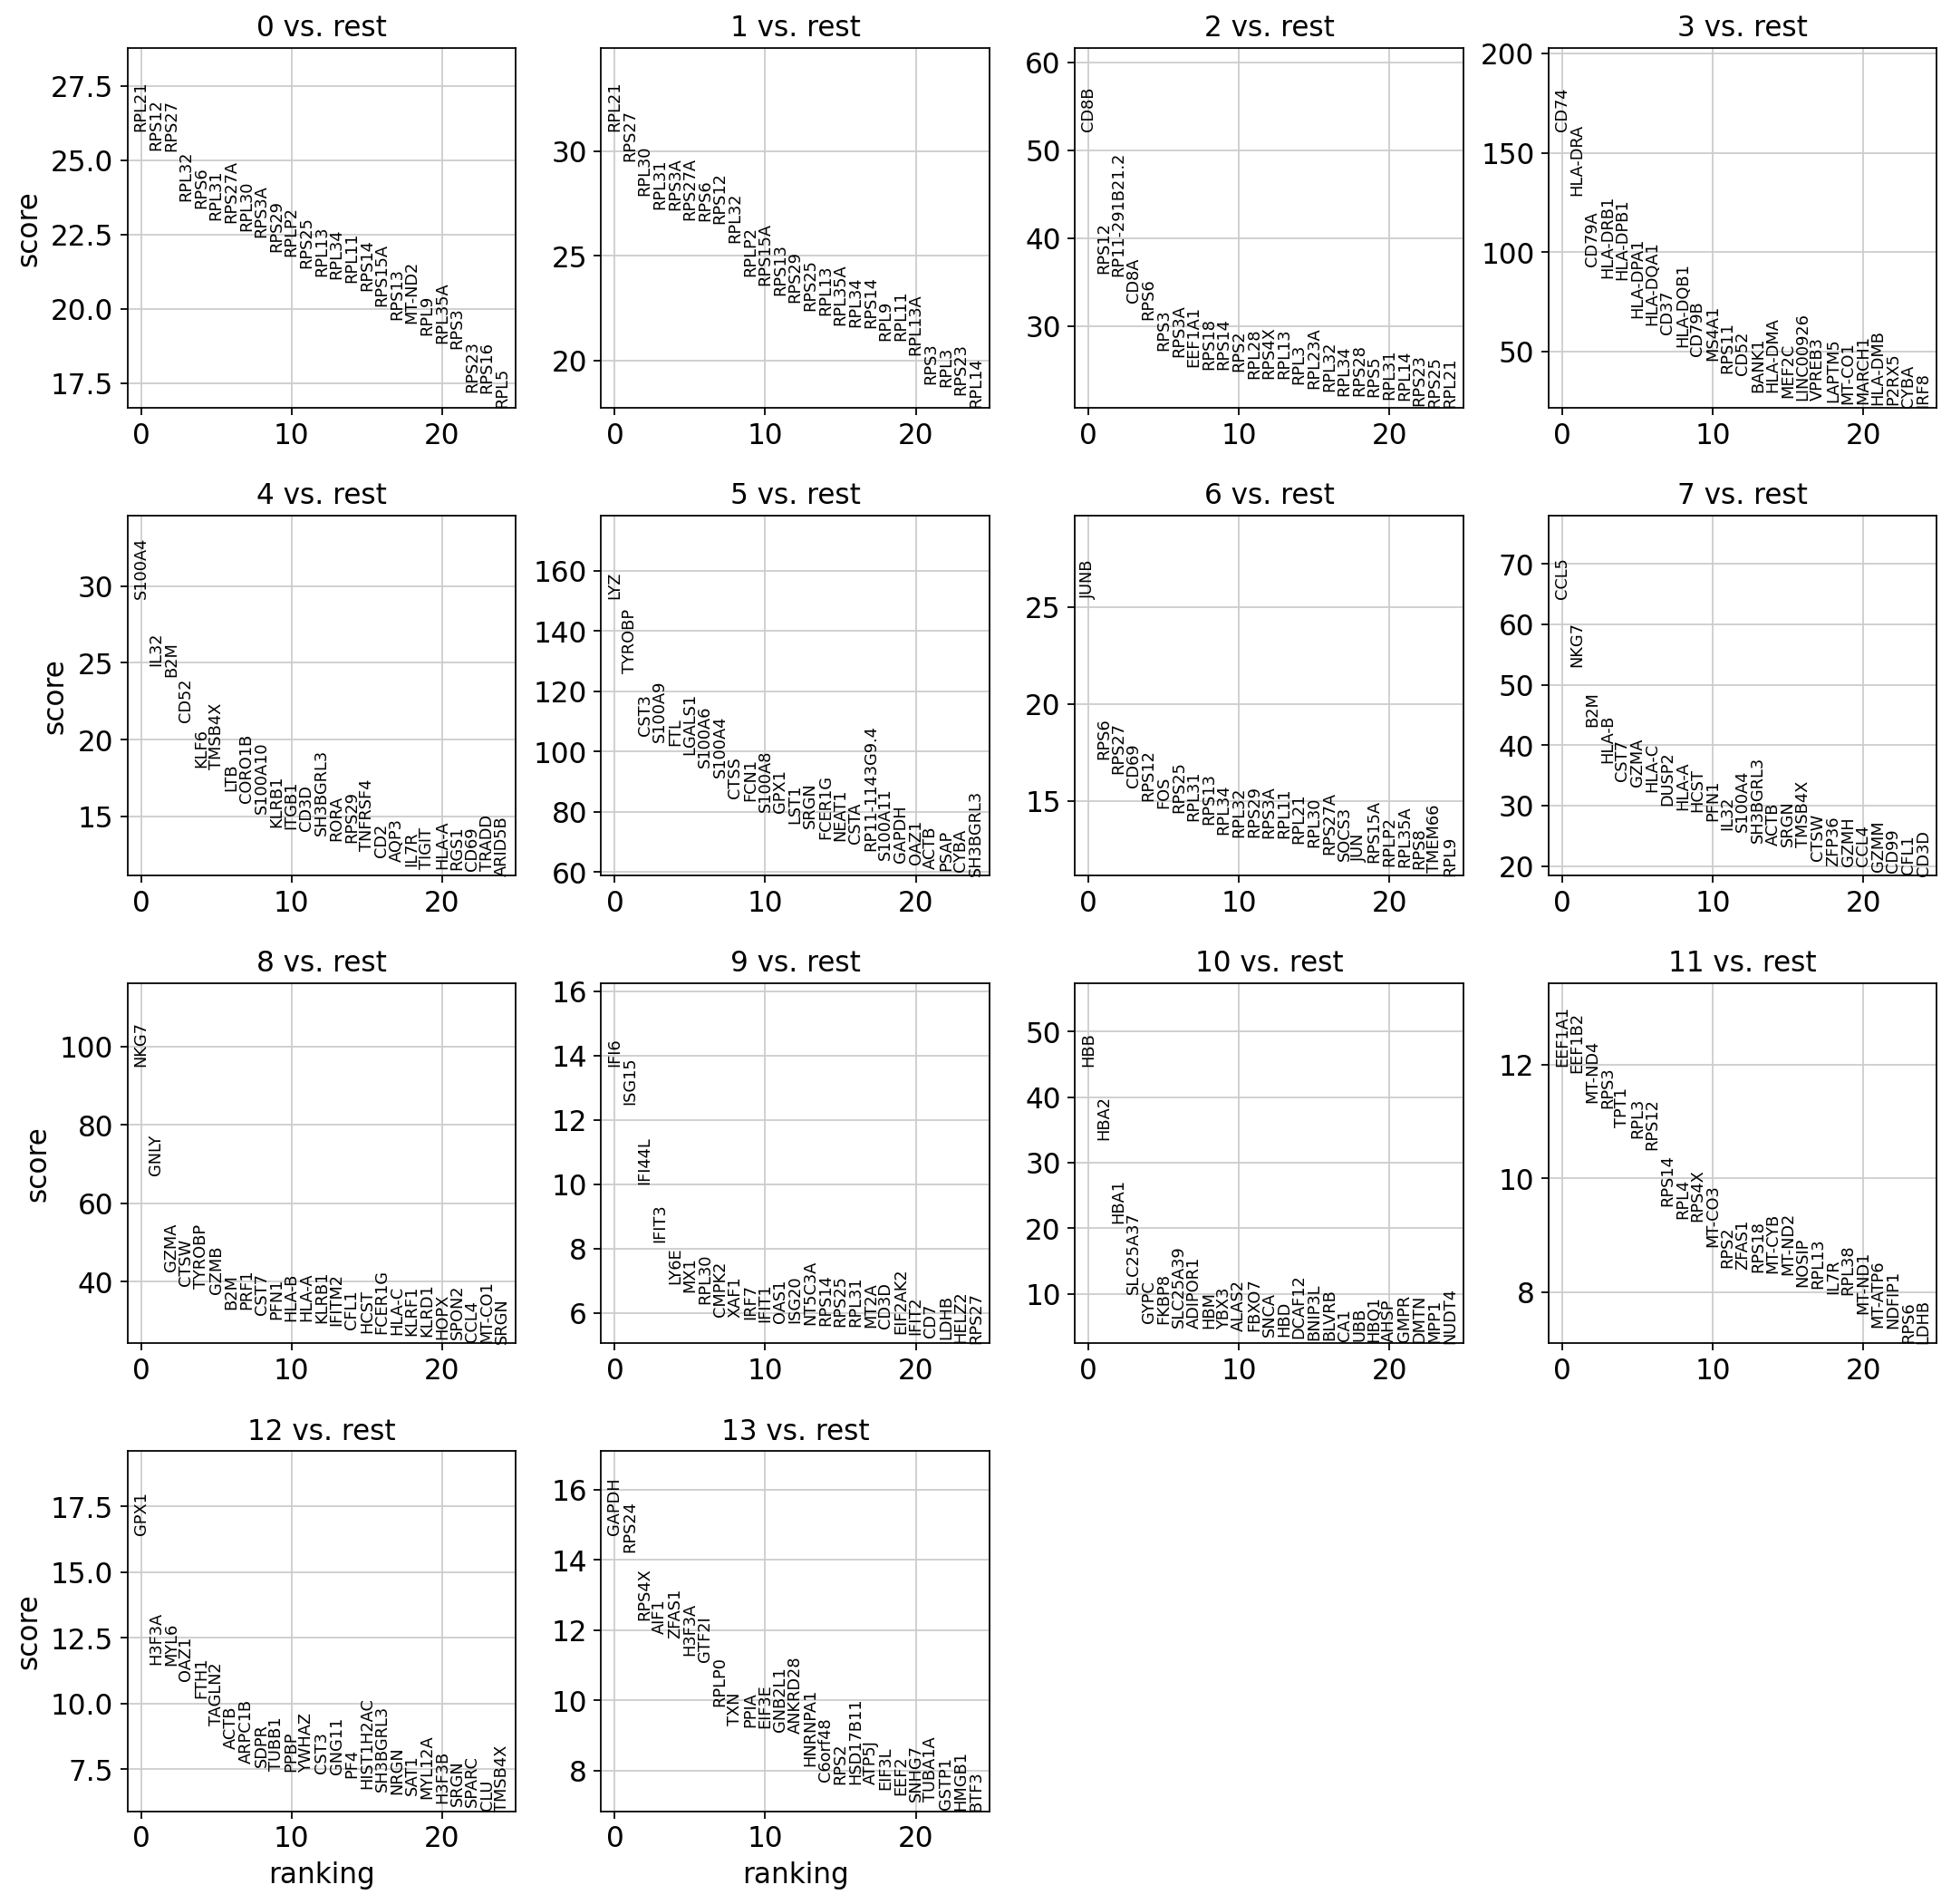

In [35]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [36]:
sc.settings.verbosity = 2  # reduce the verbosity

ranking genes
    finished (0:00:16)


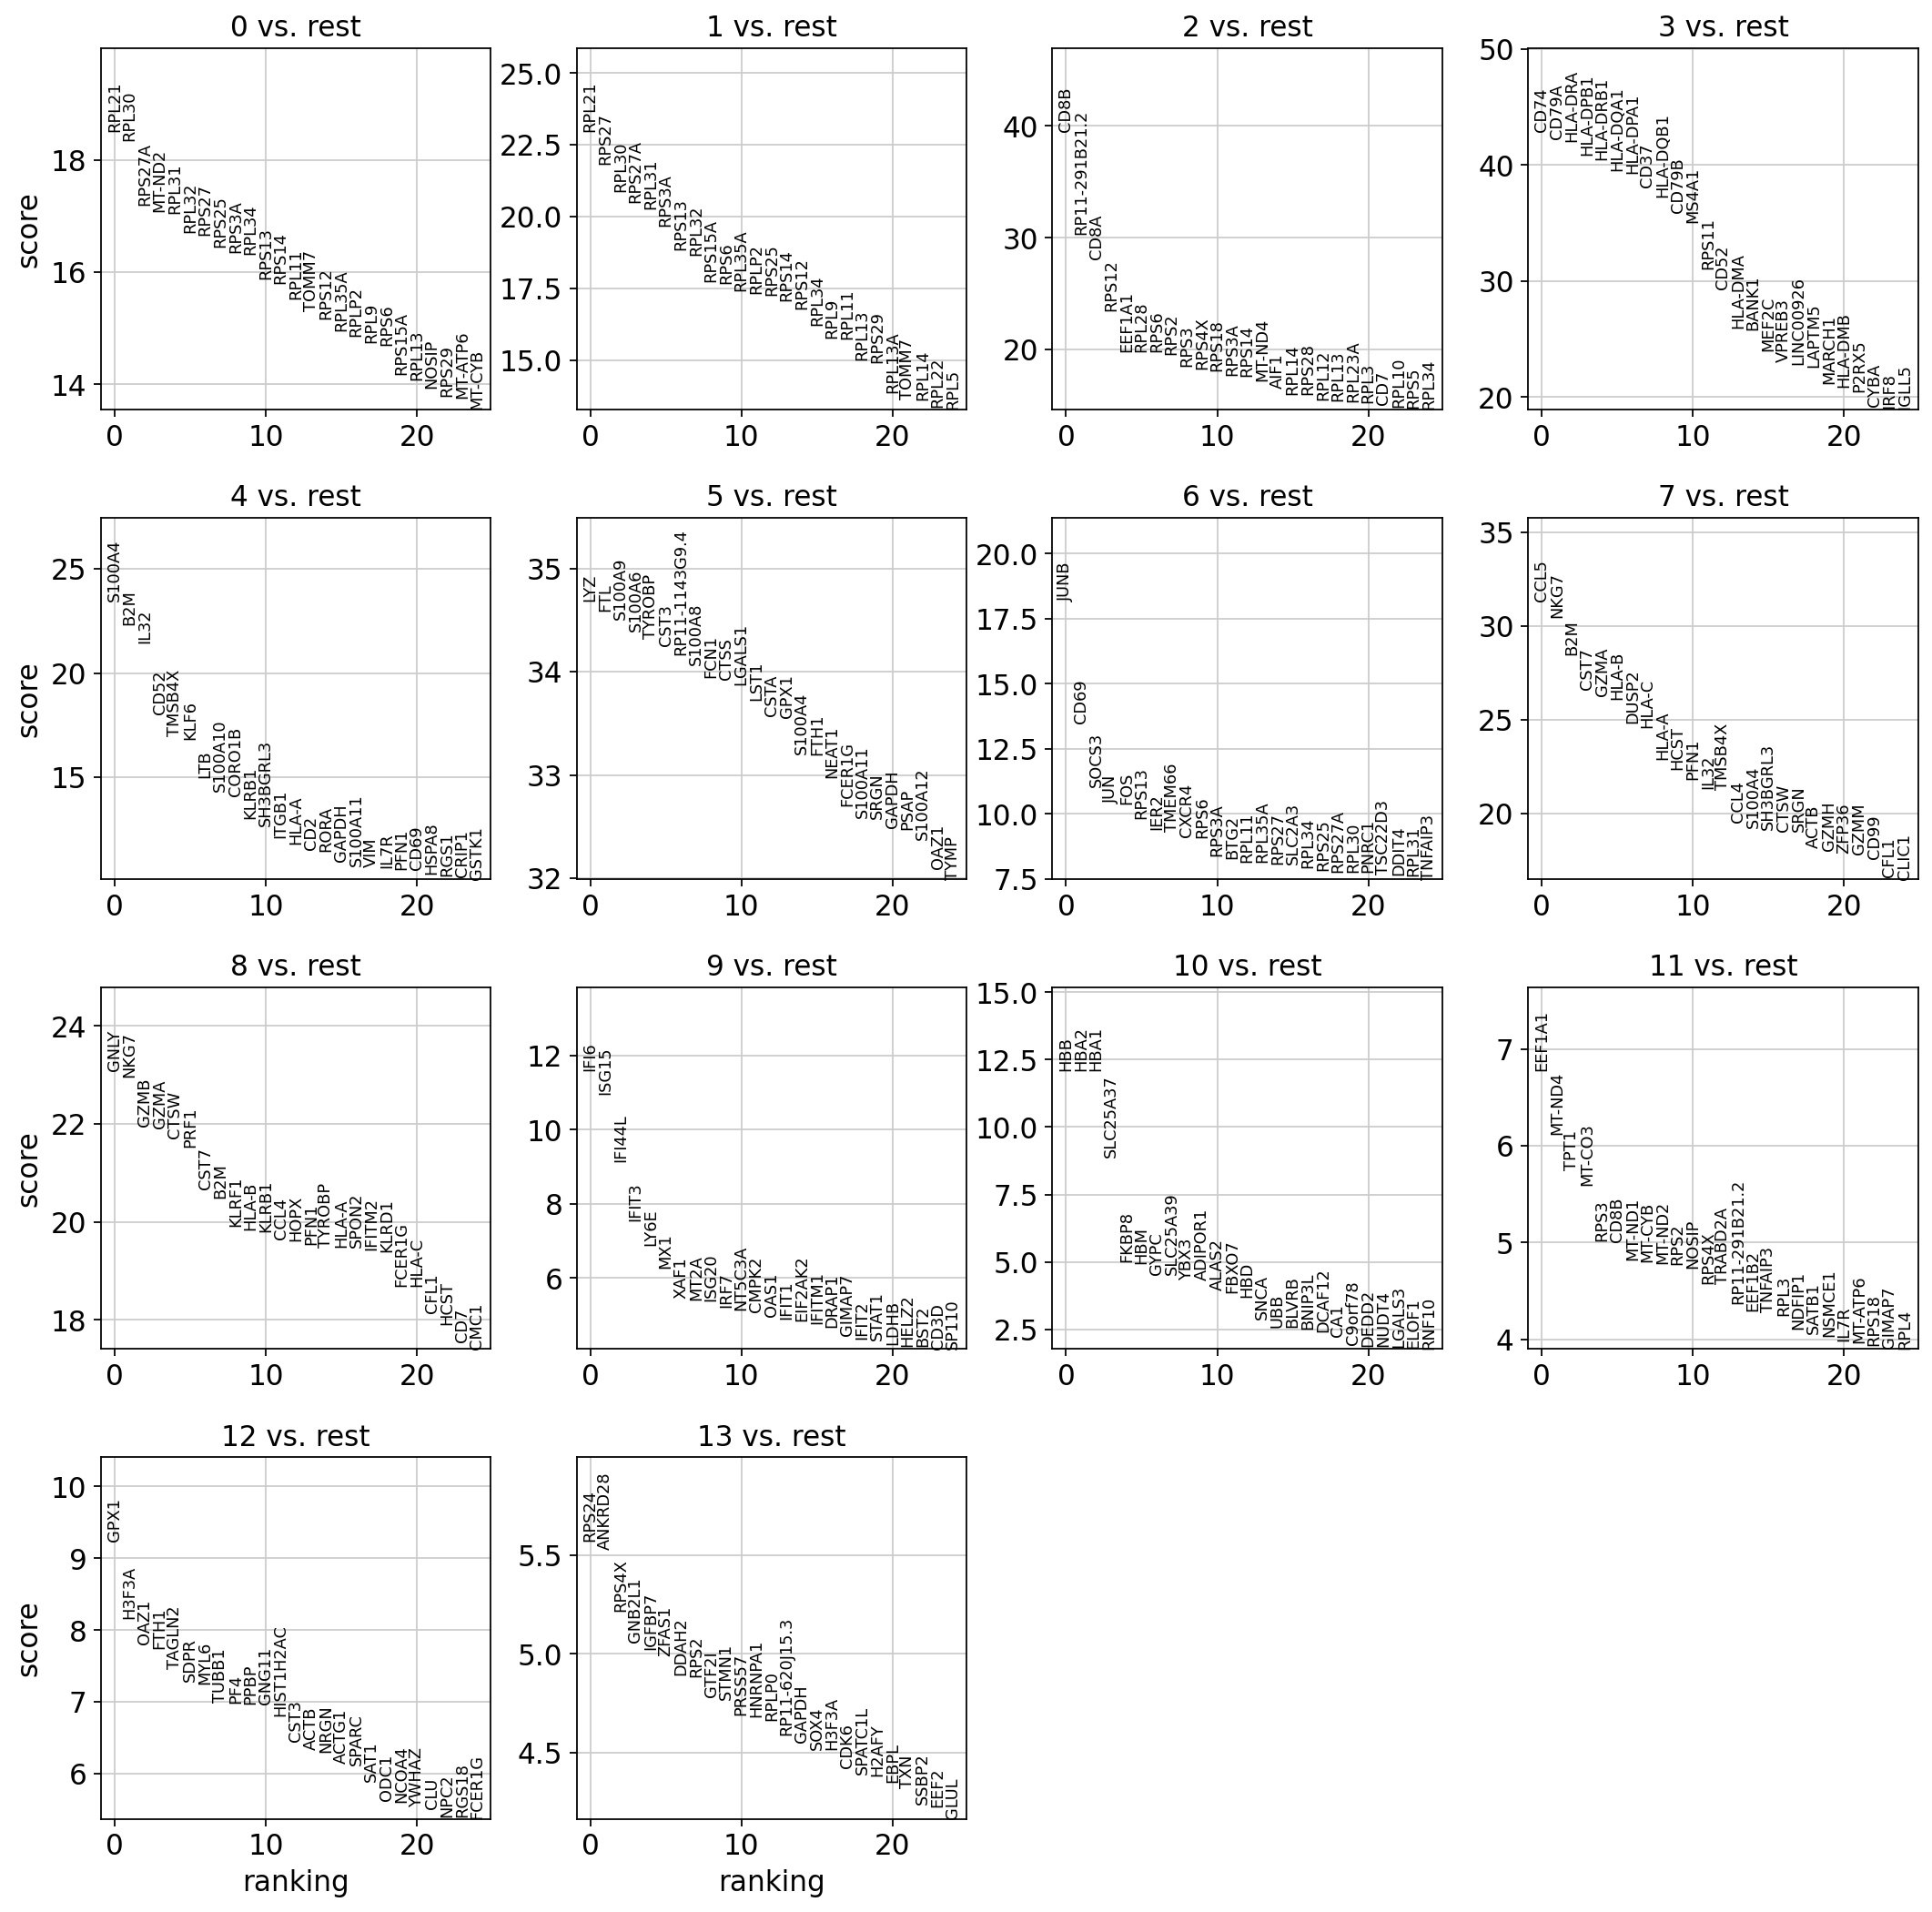

In [37]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [38]:
adata.write(results_file)

ranking genes
    finished (0:00:33)


/home/aaron/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


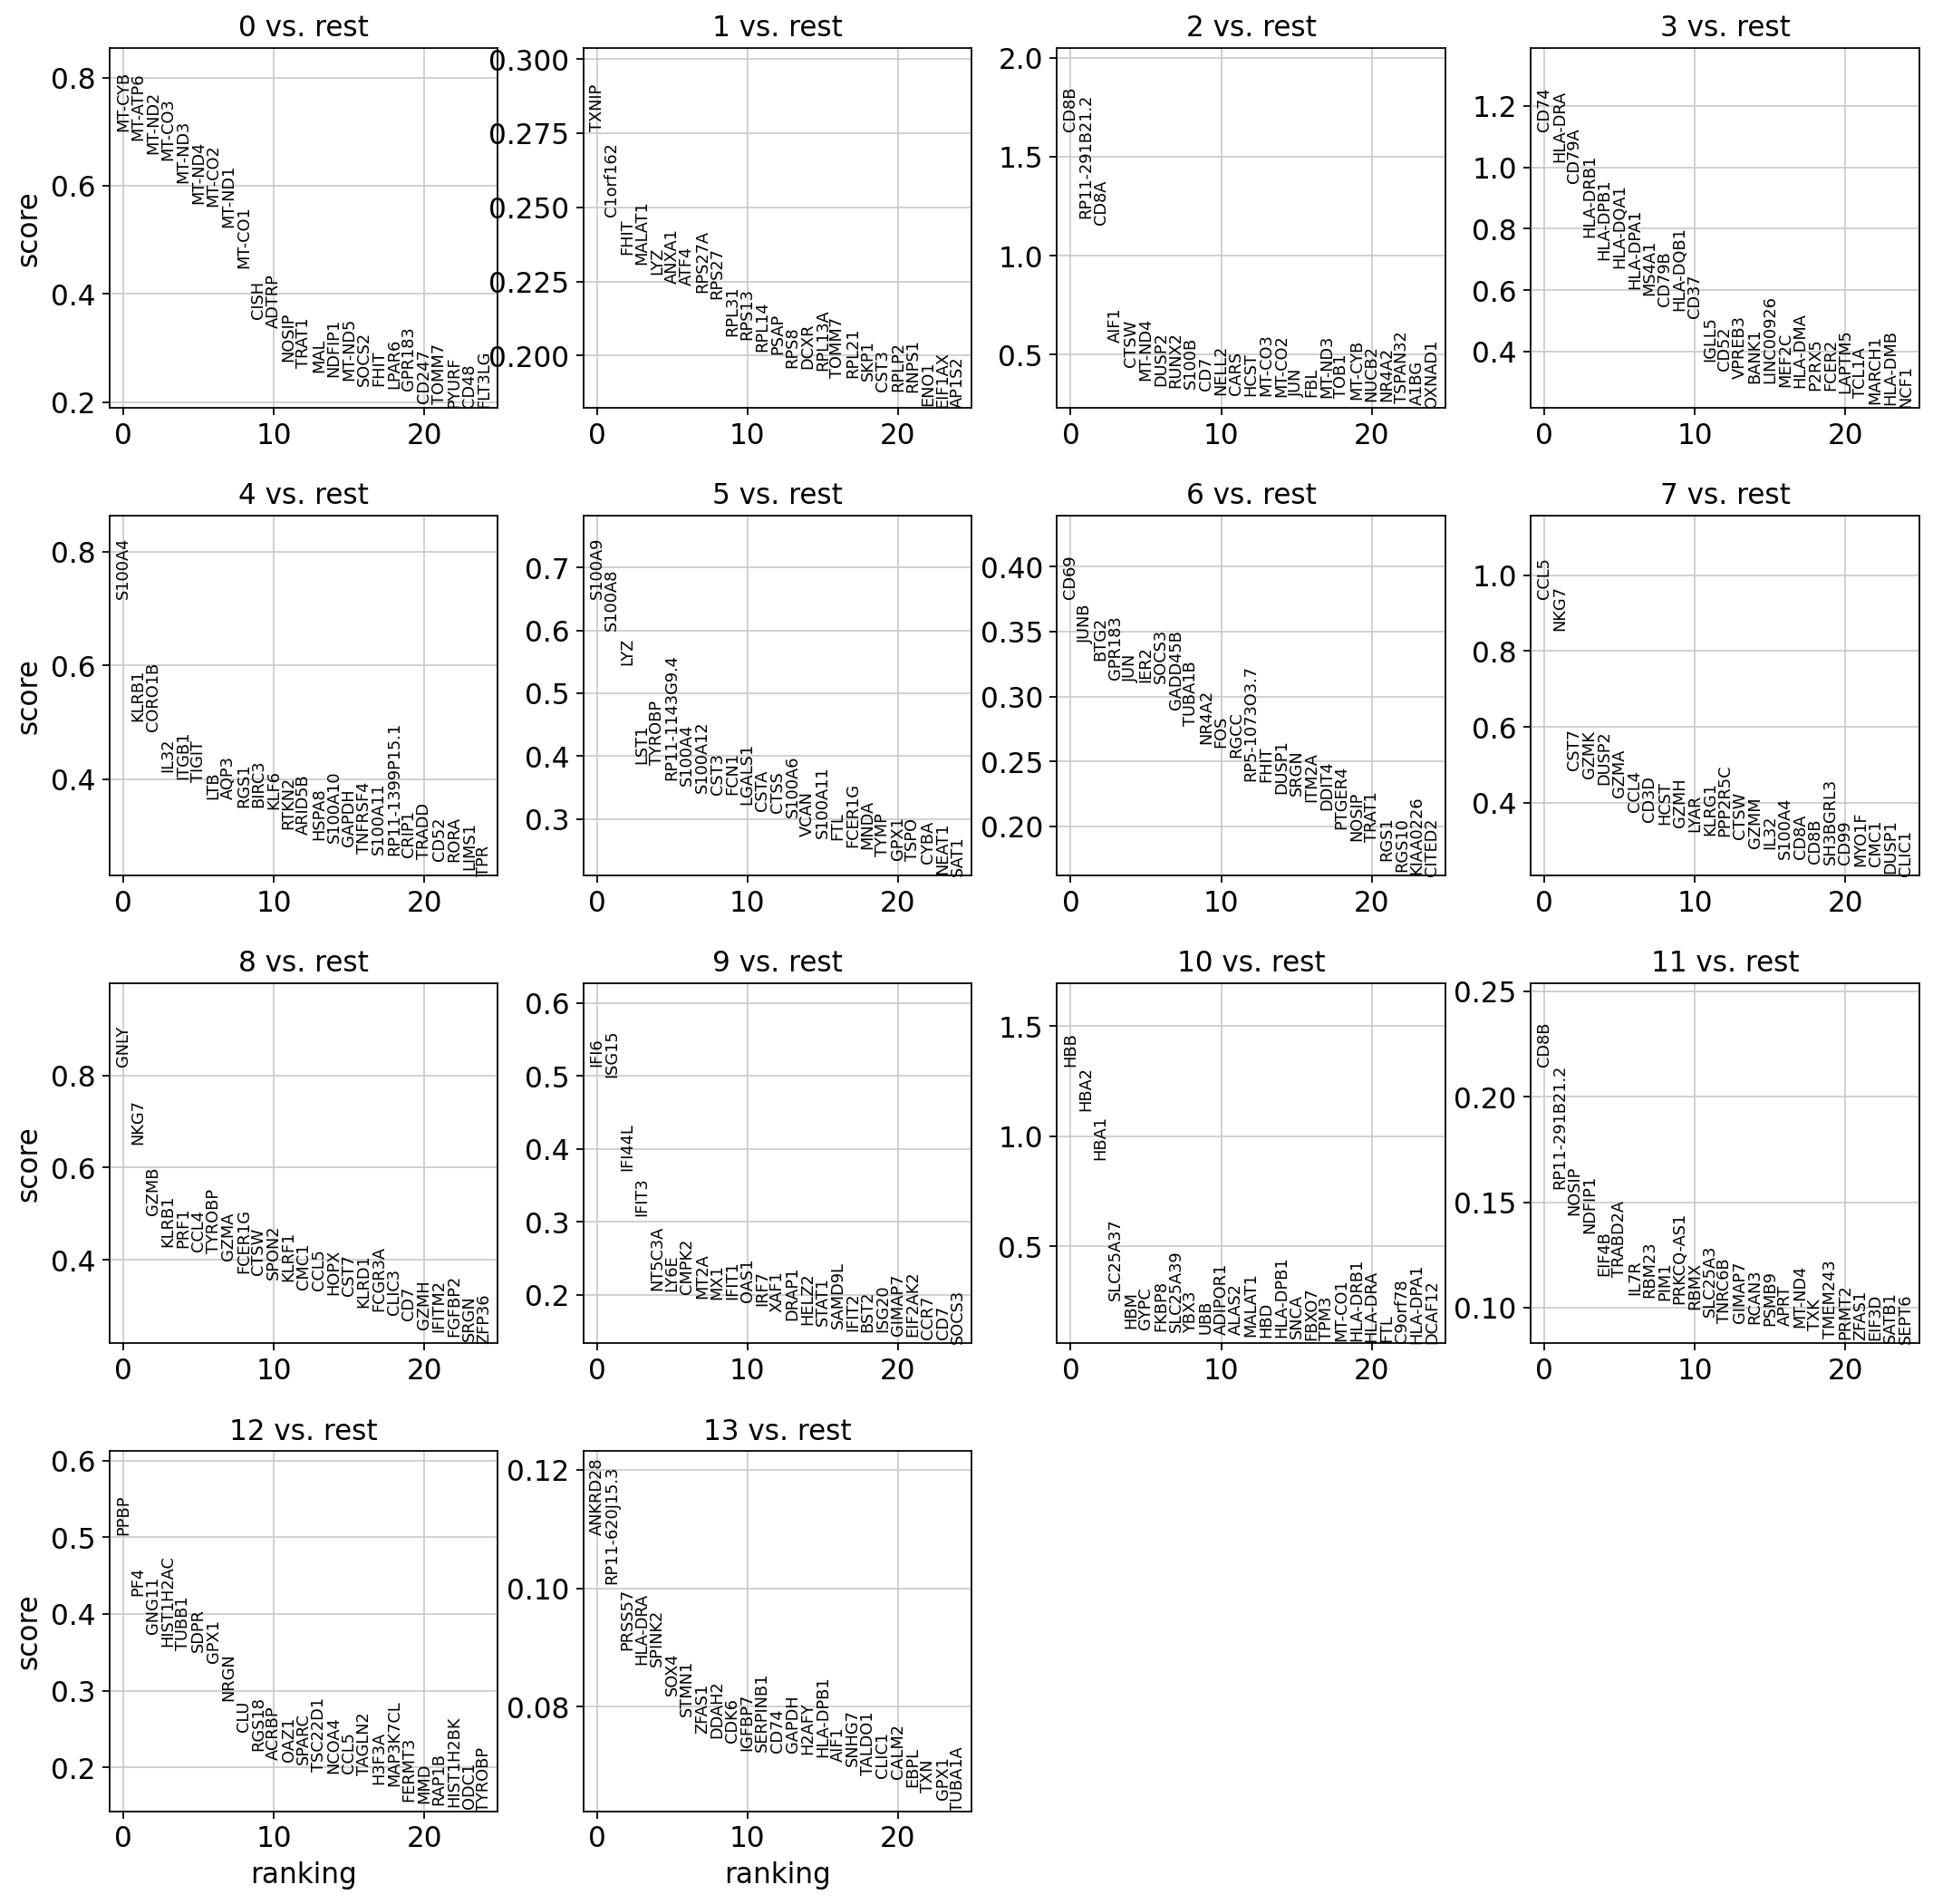

In [39]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [40]:
marker_genes = ["HBB", "PPBP","S100A8","CD14","LYZ","CST3",'CD1C',"FCER1G","FCGR3A","IL7R","CD3E","CD3D","CD8A","CD8B", "GZMA","GZMB","GZMH","GZMK", "NKG7", "MS4A1", "CD79A", "MZB1","IGJ",'LILRA4',"IRF7",'IFI44L','ISG15','IFI6']

In [41]:
adata = sc.read(results_file)

In [42]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

0       1              2         3       4       5      6     7     8  \
0   RPL21   RPL21           CD8B      CD74  S100A4     LYZ   JUNB  CCL5  GNLY   
1   RPL30   RPS27  RP11-291B21.2     CD79A     B2M     FTL   CD69  NKG7  NKG7   
2  RPS27A   RPL30           CD8A   HLA-DRA    IL32  S100A9  SOCS3   B2M  GZMB   
3  MT-ND2  RPS27A          RPS12  HLA-DPB1    CD52  S100A6    JUN  CST7  GZMA   
4   RPL31   RPL31         EEF1A1  HLA-DRB1  TMSB4X  TYROBP    FOS  GZMA  CTSW   

        9        10      11      12       13  
0    IFI6       HBB  EEF1A1    GPX1    RPS24  
1   ISG15      HBA2  MT-ND4   H3F3A  ANKRD28  
2  IFI44L      HBA1    TPT1    OAZ1    RPS4X  
3   IFIT3  SLC25A37  MT-CO3    FTH1   GNB2L1  
4    LY6E     FKBP8    RPS3  TAGLN2   IGFBP7

In [43]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

0_n           0_p     1_n            1_p            2_n            2_p  \
0   RPL21  1.925988e-76   RPL21  1.172817e-116           CD8B   0.000000e+00   
1   RPL30  3.516245e-75   RPS27  1.718844e-105  RP11-291B21.2  4.581405e-201   
2  RPS27A  3.257071e-66   RPL30   1.390771e-96           CD8A  2.936408e-173   
3  MT-ND2  2.347055e-65  RPS27A   3.156383e-93          RPS12  1.885740e-121   
4   RPL31  4.255557e-65   RPL31   2.470139e-91         EEF1A1   2.489352e-87   

        3_n  3_p     4_n            4_p  ...     9_n           9_p      10_n  \
0      CD74  0.0  S100A4  1.669737e-121  ...    IFI6  5.334301e-31       HBB   
1     CD79A  0.0     B2M  2.334320e-110  ...   ISG15  7.770835e-28      HBA2   
2   HLA-DRA  0.0    IL32  6.407614e-102  ...  IFI44L  6.657785e-20      HBA1   
3  HLA-DPB1  0.0    CD52   1.034091e-72  ...   IFIT3  4.758768e-14  SLC25A37   
4  HLA-DRB1  0.0  TMSB4X   8.231701e-65  ...    LY6E  5.940098e-12     FKBP8   

           10_p    11_n          11_p    12_n          12_p     13_n  \
0  1.405904e-33  EEF1A1  1.269846e-11    GPX1  2.383805e-20    RPS24   
1  1.418779e-33  MT-ND4  9.591959e-10   H3F3A  3.496722e-16  ANKRD28   
2  1.456782e-33    TPT1  8.756860e-09    OAZ1  6.016057e-15    RPS4X   
3  6.717008e-19  MT-CO3  2.268302e-08    FTH1  9.529311e-15   GNB2L1   
4  5.839831e-07    RPS3  5.264949e-07  TAGLN2  8.441509e-14   IGFBP7   

           13_p  
0  2.516991e-08  
1  3.203048e-08  
2  1.817995e-07  
3  4.268759e-07  
4  5.142929e-07  

[5 rows x 28 columns]

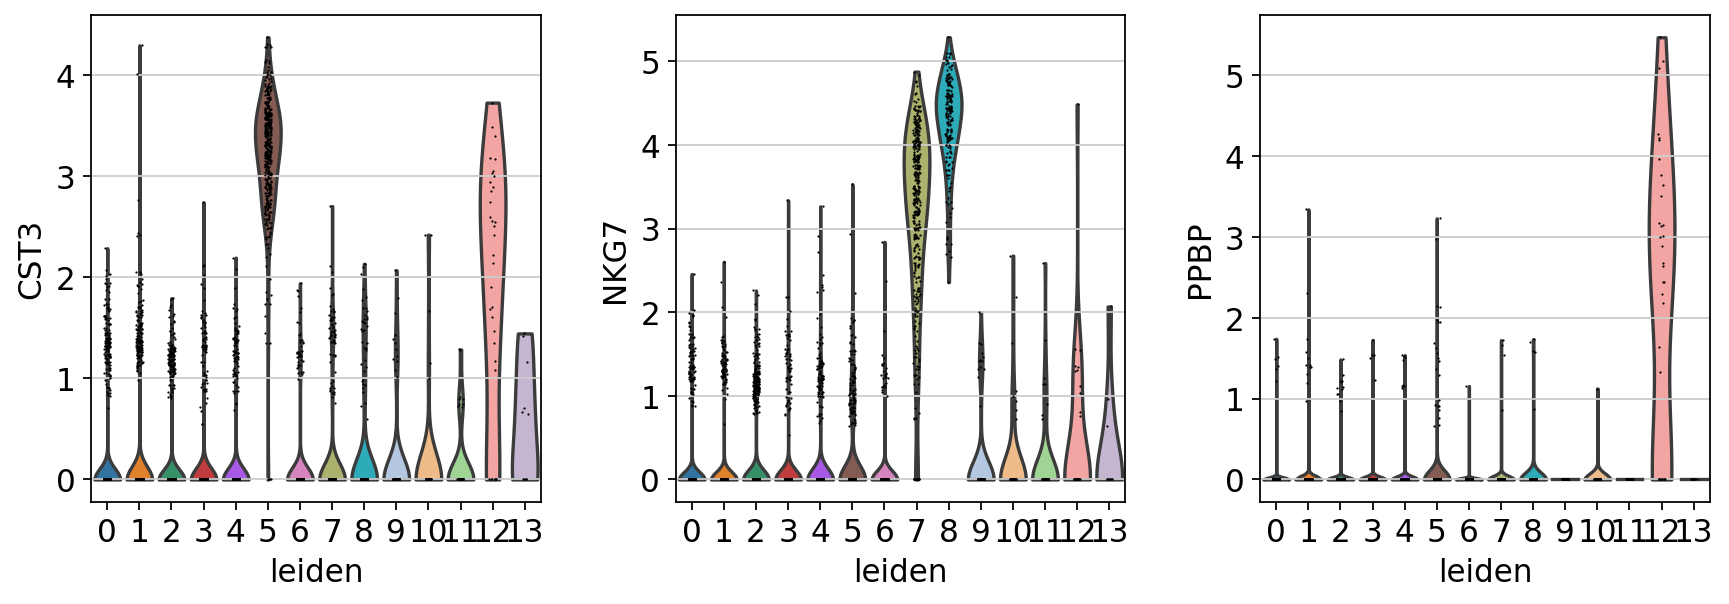

In [44]:
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='leiden')

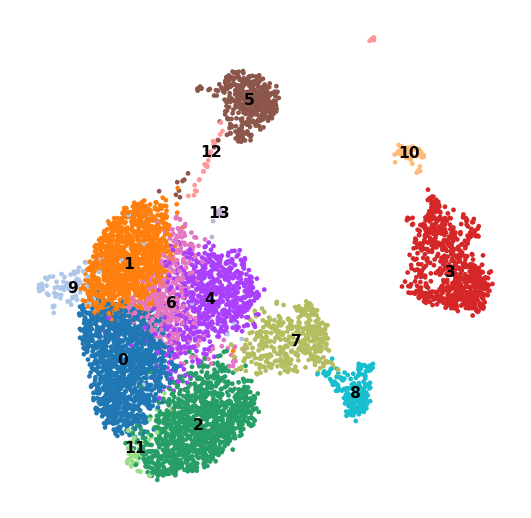

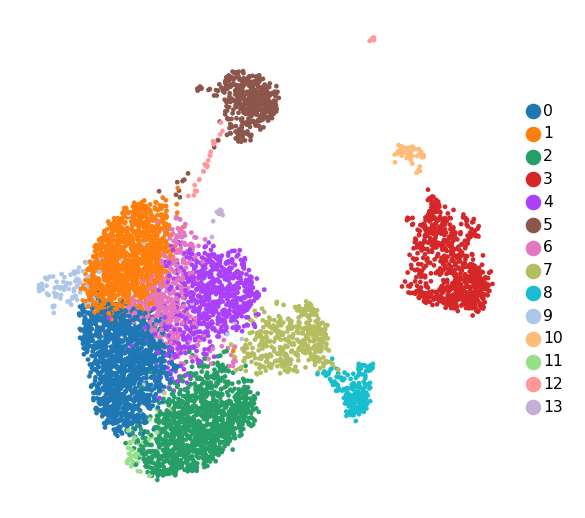

In [45]:
sc.pl.umap(adata, color='leiden', legend_loc='on data',legend_fontsize=7,  title='', frameon=False, save='.pdf')
sc.pl.umap(adata, color='leiden',legend_fontsize=7,  title='', frameon=False, save='umap2.png')


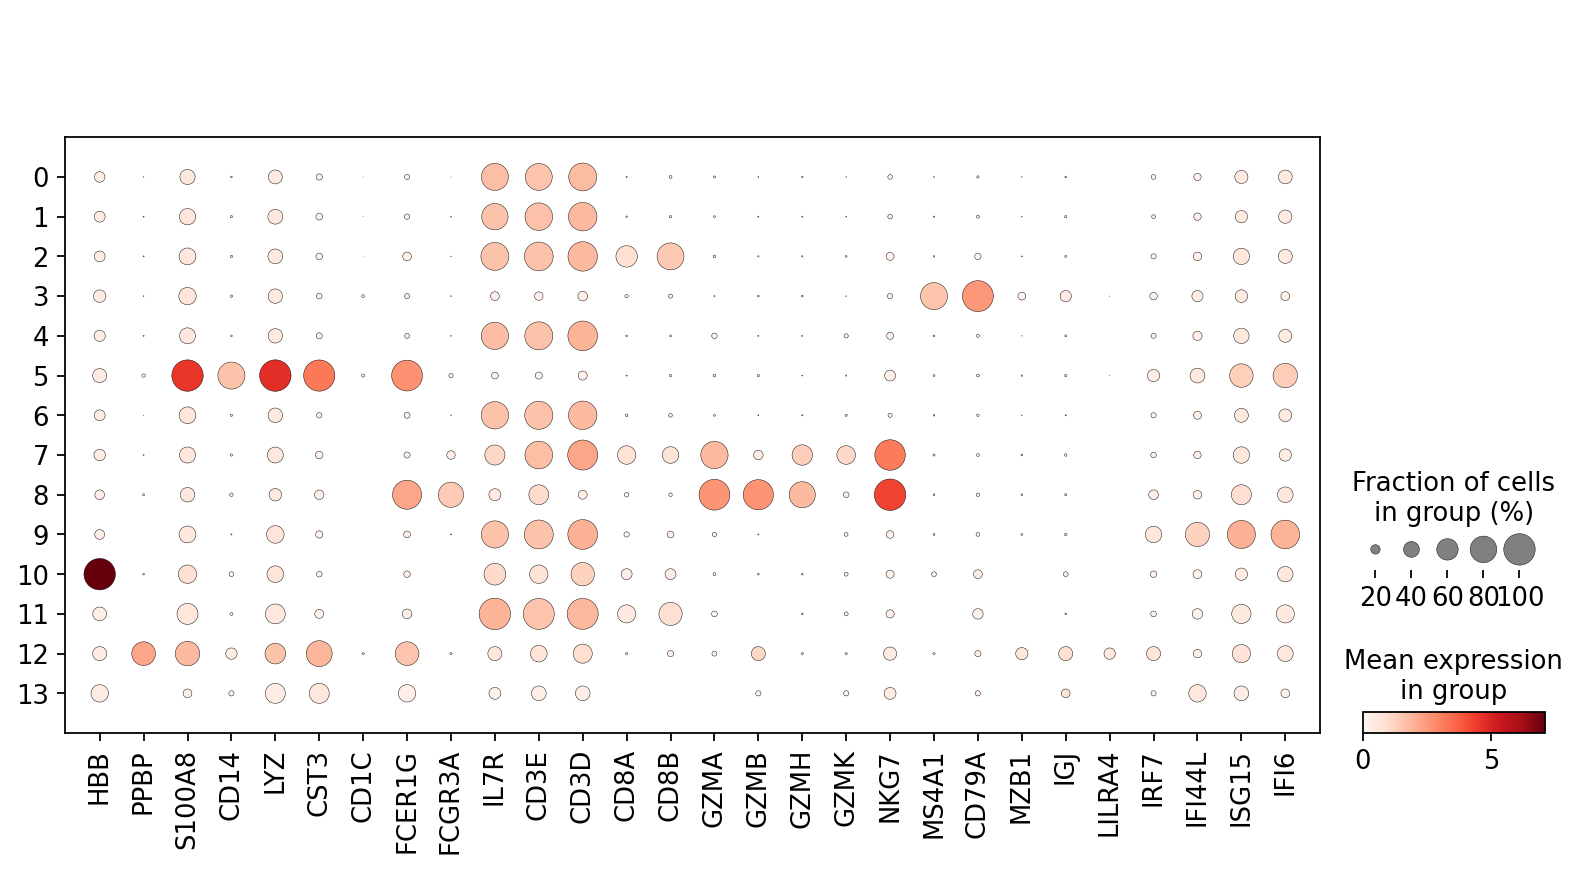

In [46]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden', save='.png');

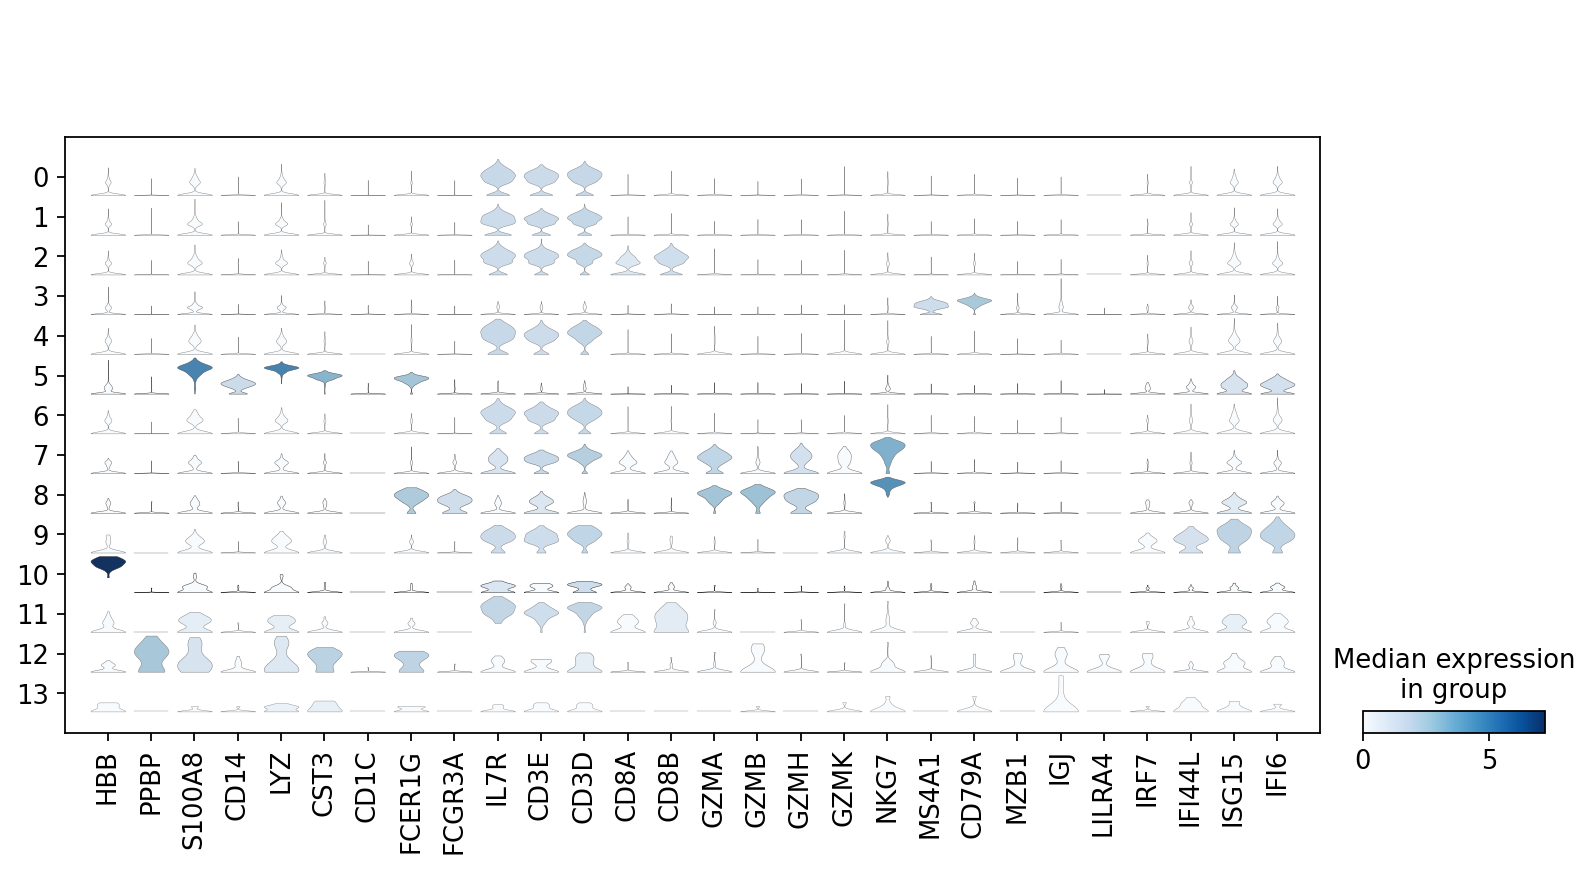

In [47]:
sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', rotation=90, save='.png');

In [48]:
adata.write(results_file, compression='gzip') 

In [49]:
adata.raw.to_adata().write('./write/pbmc3k_withoutX.h5ad')

In [50]:
# Export single fields of the annotation of observations
# adata.obs[['n_counts', 'louvain_groups']].to_csv(
#     './write/pbmc3k_corrected_louvain_groups.csv')

# Export single columns of the multidimensional annotation
# adata.obsm.to_df()[['X_pca1', 'X_pca2']].to_csv(
#     './write/pbmc3k_corrected_X_pca.csv')

# Or export everything except the data using `.write_csvs`.
# Set `skip_data=False` if you also want to export the data.
# adata.write_csvs(results_file[:-5], )